In [1]:
import pickle
import pandas as pd

from pygromos.utils import bash
from pygromos.gromos import gromosPP
from pygromos.data.ene_ana_libs import std_ene_ana_lib
gromPP = gromosPP.GromosPP()

from pygromos.files.trajectory.trg import Trg
from pygromos.files.simulation_parameters.imd import Imd

print(std_ene_ana_lib)

import glob 
import os, sys
import numpy as np
import pandas as pd
from scipy import integrate
from matplotlib import pyplot as plt

import copy


/cluster/home/cchampion/programs/PyGromosTools/pygromos/data/ene_ana_libs/ene_ana.md++.lib


In [22]:
# 1 : Do the analysis with a TI integral

leg = '1_5'

for i in range(3, 3+1):
    root_dir_ti_leg = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/openff_20ns/complex/leg_'+leg+'/seed' + str(i)
    data_dh_dl = analyse_TI(root_dir_ti_leg, num_lambdas = 21, plot_color = 'royalblue')

    # save it 
    npy_dir = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/openff_20ns/complex/results'
    np.save(npy_dir+'/NIK_'+leg+'_seed'+str(i)+'.npy', data_dh_dl)

#for i in range(1, 7):
#    root_dir_ti_leg = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/gaff/solvent/leg_1_'+str(i)+'/seed1'
#    analyse_TI(root_dir_ti_leg, num_lambdas = 21, plot_color = 'royalblue')
#    print ('\n\n')
    



Found 21 lambda directories
done working with: /cluster/home/cchampion/work/REEDS/NIK/TI_comparison/openff_20ns/complex/leg_1_5/seed3


In [ ]:
# To access the data
seed1 = data_dh_dl[0].T[-1]
lambdas = np.arange(0, 1.001, 0.05)

In [12]:
# 1: alternatively, do the analysis with MBAR
#analyse_TI_with_MBAR(root_dir_ti_leg, num_lambdas = 21)
#(lambdas, v_lambdas, mbar_results) = analyse_TI_with_MBAR(root_dir_ti_leg, num_lambdas = 21)

In [2]:
def analyse_tres_at_lambda_for_MBAR(path_tre, lambdas, index, verbose:bool = True):
    """
    This function calculates the potential energy that all states (for M-BAR analysis)
    from samples of a specific state i.  
    """ 
    
    #print (lambdas)
    
    # 1 : Load tre in pygromos
    tre = Tre(path_tre)
    v_precalc = tre.get_precalclam()
    
    N = len(lambdas)
    
    # 2: Array to store results. 
    # 3: Here we want to keep the potentials for each state separatly
    
    v_all_lambdas = np.zeros([len(lambdas), len(tre.database)]) 
    
    for i in range(len(v_all_lambdas)):     
        v_all_lambdas[i] = (1-lambdas[i]) * (v_precalc['A_e_lj_' + str(i+1)] + v_precalc['A_e_crf_' + str(i+1)]) \
                           + (lambdas[i]) * (v_precalc['B_e_lj_' + str(i+1)] + v_precalc['B_e_crf_' + str(i+1)])
        
    return v_all_lambdas

### ######

In [3]:
import pymbar
from pymbar import testsystems
from pygromos.files.trajectory.tre import Tre


# This is a tmp function so we don't have interference with new calculations running
def filter_dirs(list_lambda_dirs): 
    filtered_list = []
    filter_out = [0.0167, 0.0333, 0.0667, 0.0833, 0.9167, 0.9333, 0.9667, 0.9833]
    
    lambdas = []
    
    for lambda_dir in list_lambda_dirs:
        val = float((lambda_dir.split('/')[-1].split('_')[-1]))
        if not val in filter_out: 
            filtered_list.append(lambda_dir)
            lambdas.append(val)
    
    return filtered_list, np.array(lambdas)


def analyse_TI_with_MBAR(leg_dir, num_lambdas: int = 21, num_tres:int = 4):
    
    # find subdirectory for all lambda points. 
    lambda_dirs = sorted(list(filter( lambda x: os.path.isdir(x) and not "results" in x and not "shake" in x
                                                , glob.glob(root_dir_ti_leg+"/*"))))
    
    lambda_dirs, lambdas = filter_dirs(lambda_dirs)
        
    if len(lambda_dirs) != num_lambdas:
        print ('Warning, we did not find the directories for all 21 lambda points. Exit')
        return None
    
    # Check the dimensions based on the first file. 
    traj_e = Tre(lambda_dirs[0] + '/analysis/data/'+os.path.basename(lambda_dirs[0]) +'.tre.h5')
    num_elems = len(traj_e.get_totals())
    del traj_e
             
    # Define data structure to put results in.
    v_lambdas = [None] * num_lambdas
    for i in range(len(v_lambdas)): v_lambdas[i] = np.empty(0)
    
    
    # Here we have the data store in groups of simulated lambda
    # Perhaps we want to have it differently.
        
    # We will work on each lambda directory one by one
    #os.basename makes sure we don't have equils are alrady filtered out
    for i, lambda_dir in enumerate(lambda_dirs):        
        path_tre = glob.glob(lambda_dir+"/analysis/data/*tre.h5")[0]
                
        # Do the analysis and store results in data structure above
        v_sampled_at_i = analyse_tres_at_lambda_for_MBAR(path_tre, lambdas, index=i, verbose = False)
        
        # Insert results to the overarching datastructure.
        for i, v_sampled in enumerate(v_sampled_at_i): v_lambdas[i] = np.append(v_lambdas[i], v_sampled)
            
    print ('potential energy data now fully loaded, evaluating MBAR')
    
    num_samples = np.repeat(num_elems, len(lambdas))
    
    # Convert energies to unitless
    v_lambdas = np.array(v_lambdas)
    v_lambdas /= 2.479
    
    # TEST 1 
    # Replace very large values as test: 
    #v_lambdas[v_lambdas > 1000/2.479] = 1000/2.479
        
    # Now that all potential energies have been extracted, we can apply M-BAR
   
    mbar = pymbar.mbar.MBAR(v_lambdas, num_samples)
    results = mbar.getFreeEnergyDifferences(return_dict=True)
    
    # Print the results back out in kJ/mol: 
    dG_ab = np.round(results['Delta_f'][0][-1] * 2.479, 2)
    dG_err = np.round(results['dDelta_f'][0][-1] * 2.479, 2)

    str_result =  'MBAR estimates the free energy difference to be: ' + str(dG_ab) + \
                  ' +- ' + str(dG_err) + ' kJ/mol\n'
    
    print (str_result)
    
    out_dir = root_dir_ti_leg + '/results'
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    
    # Write the results to a text file:
    f = open(out_dir+'/mbar_results.txt', 'w')
    f.write(str_result)
    f.close()
    
    return (lambdas, v_lambdas, results)

# ####

In [4]:
from scipy import integrate

def save_TI_final_results(lambdas, data_dhdl, data_dvdl, root_dir_ti_leg, color = 'royalblue'):
    """
        lambdas: List[float]
            list of all lambdas
        data_dhdl: Tuple (List[float], List[float])
            tuple with average and standard deviations of the data
        data_dvdl:Tuple (List[float], List[float])
            tuple with average and standard deviations of the data
        root_dir_ti_leg: str 
            directory to store data in
    """
    # Make an output directory
    
    out_dir = root_dir_ti_leg + '/results'
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    
    # unpack the data
    avg_dhdl, std_dhdl = data_dhdl
    #avg_dvdl, std_dvdl = data_dvdl
    
    #return avg_dhdl, avg_dvdl
    
    # We can do a convergence analysis of this integral (chuncks we all already printed out)
    integral_dhdl = np.zeros(len(avg_dhdl.T))
    #integral_dvdl = np.zeros(len(avg_dvdl.T))
        
    for i in range(len(avg_dhdl.T)):
        integral_dhdl[i] = np.round(integrate.simps(x=lambdas, y=avg_dhdl.T[i]),2)
        #integral_dvdl[i] = np.round(integrate.simps(x=lambdas, y=avg_dvdl.T[i]),2)
    
    # Write the results to a text file:
    f = open(out_dir+'/ti_integral.txt', 'w')
    f.write('This file contains the TI integral evaluated using the first n% of the data.\n')
    f.write('\nPercent\tdHdl\tdVdl\n')
    
    
    for i, v1 in enumerate(integral_dhdl):
        percent = str((i+1)/len(integral_dhdl)*100)
        f.write(percent + '%\t'+str(v1)+'\n')
    f.close()
    
    #for i, (v1, v2) in enumerate(zip(integral_dhdl, integral_dvdl)):
    #    percent = str((i+1)/len(integral_dvdl)*100)
    #    f.write(percent + '%\t'+str(v1)+'\t'+str(v2)+'\n')
    #f.close()

    # Plot the TI profile
    plot_TI_profile(lambdas, avg_dhdl.T[-1], std_dhdl.T[-1], integral_dhdl[-1], root_dir_ti_leg, color = color)
    
    return None

# Below are the functions which do the job

In [5]:

# Helper function to sort numerically
def sort_trgs(list_trgs):
    return sorted(list_trgs, key=lambda x: x.split('_')[-1].replace('.trg.gz', ''))

def sort_dirs(list_dirs):
    return sorted(list_dirs, key=lambda x: x.split('_')[-1])

def analyse_TI(leg_dir, num_lambdas: int = 21, plot_color = 'royalblue'):
    
    # find subdirectory for all lambda points. 
    lambda_dirs = sort_dirs(list(filter( lambda x: os.path.isdir(x) and not "results" in x 
                                                , glob.glob(leg_dir+"/*"))))
    
    print ('Found ' + str(len(lambda_dirs)) + ' lambda directories')
    
    if len(lambda_dirs) != num_lambdas:
        print ('Warning, we did not find the directories for all 21 lambda points. Exit')
        return None
    
    # Define data structures to put results in.
    
    # This is to perform a convergence analysis
    conv_slice = np.arange(10, 101, 10) / 100
    
    lambdas = np.zeros(num_lambdas)
    
    avg_dhdl = np.zeros([num_lambdas, 10])
    std_dhdl = np.zeros([num_lambdas, 10])
    
    avg_dvdl = np.zeros([num_lambdas, 10])
    std_dvdl = np.zeros([num_lambdas, 10])
    
    # We will work on each lambda directory one by one
    for i, lambda_dir in enumerate(lambda_dirs):               
        # Get value of lambda from imd 
        imd_path = lambda_dir+"/input/"+os.path.basename(lambda_dir)+".imd"
        imd = Imd(imd_path)
        lambda_sim = float(imd.PERTURBATION.RLAM)
        lambdas[i] = lambda_sim
        
        # Find the .trg.h5 file written automatically by pyGromos.
        trg_path = lambda_dir+"/analysis/data/"+os.path.basename(lambda_dir)+".trg.h5"
                
        if os.path.exists(trg_path):
            pass#continue
        else:
            print ('missing: ' + trg_path)
            continue
        
        trg = Trg(trg_path)
        
        # Get the values we care about
        dh_dl = trg.get_totals()["dHdl"]
        #dv_dl = trg.get_totals()["dVdl"]
        
        avg_dhdl[i] = np.array([np.average(dh_dl[:int(i*len(dh_dl))]) for i in conv_slice])
        std_dhdl[i] = np.array([np.std(dh_dl[:int(i*len(dh_dl))]) for i in conv_slice])
        
        #avg_dvdl[i] = np.array([np.average(dv_dl[:int(i*len(dv_dl))]) for i in conv_slice])
        #std_dvdl[i] = np.array([np.std(dv_dl[:int(i*len(dv_dl))]) for i in conv_slice])
        
        # Plot some of the properties
        plot_dXdl_timeseries(dh_dl, leg_dir, lambda_sim)        
    
   
    
    # Once all values have been read-in. Draw the TI profile   
    data_dhdl = (avg_dhdl, std_dhdl)
    data_dvdl = None # data_dvdl = (avg_dvdl, std_dvdl)
    
    #print ('Skipping the calculation (go back to function to add it back)')
    #return data_dhdl
    
    save_TI_final_results(lambdas, data_dhdl, data_dvdl, leg_dir, plot_color)
    
    print ('done working with: ' + leg_dir)
    return data_dhdl

# Below is the function doing the plotting

In [6]:
def plot_TI_profile(lambdas, avg_dXdl, std_dXdl, integral_dXdl, root_path, color = 'royalblue'):
    """
        Gvie a brief explanation here
    """
    
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=[8,6])

    # plot basic data
    plt.errorbar(lambdas, avg_dXdl, std_dXdl, fmt='-', color = color, 
                 ecolor = 'black', elinewidth=1, capsize=2, capthick=1, barsabove=True)

    plt.scatter(lambdas, avg_dXdl, marker='x', color='darkgrey', s=24)

    # Label axes and plot title 

    plt.xlabel(r'$\lambda$', fontsize = 16)
    plt.xlim(0, 1)

    plt.ylabel(r' ${\partial V}$ / ${\partial \lambda}$ [kJ/mol]  ', fontsize = 16)
    plt.ylim(1.25 * min(avg_dXdl), 1.25*max(avg_dXdl))
    
    # Get other names for title of the plot - note this can change depending on path!!!
    names = root_path.split('/')
    legs = names[-2].split('_')
        
    title = 'TI profile - ' + names[-4] + ' ' + names[-3] + ' ' + legs[1] + r'$\rightarrow$ ' + legs[2] 

    plt.title(title, fontsize=16)
    
    # Plot the value of the integral
    
    plt.text(0.5,max(avg_dXdl) * 1.1,r'$\int_{0}^{1} \frac{\partial V}{\partial \lambda}$ ${d\lambda} = %s $ kJ/mol'%integral_dXdl, 
             horizontalalignment='center', verticalalignment='center',fontsize = 12)

    #ax.patch.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.savefig(root_path+'/results/ti_profile.png', dpi=300)
    
    
    plt.close()
    return None

def plot_dXdl_timeseries(dXdl, root_path, lambda_sim):
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=[9,6])
    
    if os.path.isfile(root_path+'/results/dvdl_timeseries_'+str(lambda_sim)+'.png'):
        plt.close()
        return None # skip plotting for this as it already exists
    
    N = 100
    convoluted = np.convolve(dXdl, np.ones(N)/N, mode='valid')
    
    axes.plot(dXdl, label = 'raw data')
    axes.plot(convoluted, label = 'running average')
    axes.axhline(np.average(dXdl), label = 'global average', color = 'black')
    
    # note this depends on print frequency... but works for my stuff
    axes.set_xlabel(' time [ps]', fontsize = 12) 
    axes.set_ylabel(r'${\partial V}$ / ${\partial \lambda}$ [kJ/mol]', fontsize = 12)
   
    axes.set_ylim(min(dXdl)-100, max(dXdl)+100)
    axes.legend()
    
    plt.title(r'${\partial V}$ / ${\partial \lambda}$ timeseries for $\lambda = %s$'%lambda_sim)
    
    fig.patch.set_facecolor('white')
    plt.savefig(root_path+'/results/dvdl_timeseries_'+str(lambda_sim)+'.png', dpi=300)
    
    plt.close()
    return None 

## Backup: TI analysis with slightly different integration method with CBSMS exercise way of doing it

In [7]:
import scipy.interpolate as ip
import scipy.integrate as ig

#trapezoid function
def trapezoid(y, x, cumsum=[]):
    integral = 0.0
    cumsum.append(integral)
    for i in range(len(y)-1):
        inc = (y[i]+y[i+1])*(x[i+1]-x[i])/2.0
        integral += inc
        cumsum.append(integral)
    return integral


dhdl_data

#integrate data
s = []
integral1 =  trapezoid(dhdl_data, lambdas, cumsum=s)
#error1 = trapezoid(data[:,2], data[:,0])

#cubic spline fit to data
f = ip.interp1d(lambdas, dhdl_data, kind='cubic')

#evaluate spline fit on 100 equispaced points between 0 and 1
xnew = np.linspace(0,1,100)
ynew = f(xnew)

#integrate fit
s2 = []
integral2 =  trapezoid(ynew, xnew, cumsum=s2)

#plot data
fig = plt.figure()
ax  = plt.subplot(111)
ax.scatter(lambdas, dhdl_data,label='simulated')
ax.plot(lambdas, s, label='int simulated')


#plot spline
ax.plot(xnew, ynew, label='cubic spline fit')
ax.plot(xnew, s2, label='int spline fit')
#title, labels and legend
#plt.title(str(sys.argv[2]).replace("_", " "))
#plt.xlabel("$\lambda$")
#plt.ylabel(r'$\langle \partial H / \partial \lambda \rangle_{\lambda}$')
#change default order of labels
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=[handles[3]]+handles[:3],loc="best")

#save figure
#plt.savefig(str(sys.argv[1]))

#print integration results
print("# integrated(python) " + str(integral1))
print("# integrated after cubic spline fitting(python) " + str(integral2))

NameError: name 'dhdl_data' is not defined

# Torsion Analysis with plots ! 

In [8]:
import numpy as np
from pygromos.gromos import gromosPP
gromPP = gromosPP.GromosPP()


def modulo_2PI(number):
    while number > 180.0 or number < -179.9999:
        if number > 180.0 : number -= 360
        if number < -179.9999: number += 360
    return number

def parse_gromos_torsion_data(infile):
    # Read in the header briefly 

    labels = []
    for line in open(infile, "r"):
        if '#' in line and 'time' in line:
            labels = line.split()[1:]
            break
    data = np.empty((len(labels), 0)).tolist()
    # Read the entire file now:
    for line in open(infile, "r"):
        if '#' in line: continue
        fields = line.split()
        for i in range(len(fields)):
            if i == 0: data[i].append(float(fields[i])) # this is the time
            else : data[i].append(modulo_2PI(float(fields[i]))) # this are the torsions
                
    # When reading consecutive files, the time resets at 0. 
    # This resets the time properly, assuming the delta t is always the same.
    num_elems = int(len(data[0]))
    new_time = np.linspace(0, data[0][1]*num_elems, num=num_elems)
    data[0] = new_time
    return labels, data

def plot_gromos_timeseries(outfile, data, labels, plot_color, lambda_sim):

    nrows = 2
    ncols = int((len(labels) - 1) / nrows)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = [10, 8])

    fig.suptitle(r'NIK - GAFF - TI torsions $\lambda = $' + str(lambda_sim), fontsize = 14)

    col_num = 0
    row_num = 0
    if len(labels) == 2: # 2 labels = time and 1 other
        #fig.scatter(data[0], data[1], color='royalblue', s = 4, marker = 'D', label = labels[i])


        axes.scatter(data[0], data[1], color='firebrick', s = 4, marker = 'D', label = labels[1])
        axes.set_title(labels[1])
        axes.set_ylim([-180, 180])
        axes.set_xlabel('time [ps]')
        axes.set_ylabel(r'$\omega$ - [degrees]')
    elif len(labels) == 3:
        axes[0].scatter(data[0], data[1], color=plot_color, s = 4, marker = 'D', label = labels[1])
        axes[1].scatter(data[0], data[2], color=plot_color, s = 4, marker = 'D', label = labels[2])

        axes[0].set_title(labels[1])
        axes[1].set_title(labels[2])

        axes[0].set_ylim([-180, 180])
        axes[1].set_ylim([-180, 180])

        axes[0].set_xlabel('time [ps]')
        axes[0].set_ylabel(r'$\omega$ - [degrees]')

        axes[1].set_xlabel('time [ps]')
        axes[1].set_ylabel(r'$\omega$ - [degrees]')


    else :
        for i in range(1, len(labels)):
            axes[row_num, col_num].scatter(data[0], data[i], color=plot_color, s = 4, marker = 'D', label = labels[i])
            #axes[col_num].scatter(data[0], data[i], color='firebrick', s = 4, marker = 'D', label = labels[i])

            axes[row_num, col_num].set_title(labels[i])
            axes[row_num, col_num].set_ylim([-180, 180])
            axes[row_num, col_num].set_xlabel('time [ps]')
            axes[row_num, col_num].set_ylabel(r'$\omega$ - [degrees]')

            if col_num == ncols-1:
                col_num =  0
                row_num += 1
            else :
                col_num += 1

    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()
    return None


In [9]:
root_dir_ti_leg = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/gaff/complex/leg_1_2/seed1'
topology = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/gaff/complex/leg_1_2/input/NIK_complex_TI_1_2.top'

# leg 1->2
torsion = 't%1:14,13,15,16 t%2:12,7,6,2'

# leg 1->3
# torsion = 't%1:14,13,15,16 t%2:10,11,15,19'

# leg 1->4
# torsion = 't%1:14,13,15,16 t%2:9,10,14,22'

# leg 1-> 5 
#torsion = 't%1:14,13,15,16 t%2:10,11,15,23'

# leg 1-> 6
#torsion = 't%1:14,13,15,16 t%2:10,11,12,21'


In [10]:
plot_torsions_all_TI_lambdas(root_dir_ti_leg, topology, plot_color = 'royalblue')

NameError: name 'plot_torsions_all_TI_lambdas' is not defined

In [11]:
def plot_torsions_all_TI_lambdas(leg_dir, topology, num_lambdas: int = 21, plot_color = 'royalblue'):
    
    # find subdirectory for all lambda points. 
    lambda_dirs = sort_dirs(list(filter( lambda x: os.path.isdir(x) and not "results" in x 
                                                , glob.glob(root_dir_ti_leg+"/*"))))
    
    print ('Found ' + str(len(lambda_dirs)) + ' lambda directories')
        
    
    if len(lambda_dirs) != num_lambdas:
        print ('Warning, we did not find the directories for all 21 lambda points. Exit')
        return None
    
    # Define data structure to put results in.
        
    # 
    tmp_root = os.path.dirname(lambda_dirs[0])
    if not os.path.isdir(tmp_root + '/results/torsions'):
        os.mkdir(tmp_root + '/results/torsions')
    
    # We will work on each lambda directory one by one
    #os.basename makes sure we don't have equils are alrady filtered out
    for i, lambda_dir in enumerate(lambda_dirs):        
        trc_repex = lambda_dir+"/simulation/"+os.path.basename(lambda_dir)+"*/*trc.gz"
        trcs = sort_trgs(glob.glob(trc_repex))
        
        lam = float(trcs[0].split('/')[-1].split('_')[-2]) 
        
        torfile = tmp_root + '/results/torsions/torsions_lam' + str(lam).replace('.', '') + '.csv'
        
        # Get the torsion values
        if not os.path.isfile(torfile):
            gromPP.tser(in_trc_path= ' '.join(trcs), 
                        in_top_path = topology,
                        out_csv_path = torfile,
                        periodic_boundary_condition = 'r cog',
                        property = torsion
                       )
        # Read in data 
        labels, data = parse_gromos_torsion_data(torfile)
        
        out_file = tmp_root + '/results/torsions/torsions_lam' + str(i) + '.png'
        # plot the data        
        plot_gromos_timeseries(out_file, data, labels, plot_color, lam)
            
    return None

NameError: name 'lambdas' is not defined

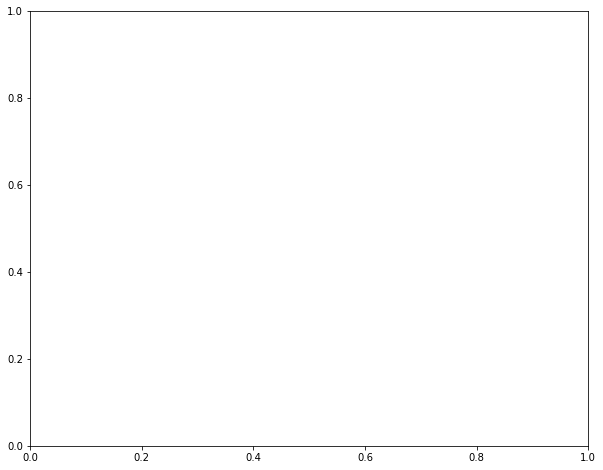

In [12]:
#
# I used this to overlay the different TI profiles
#

%matplotlib inline

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = [10, 8])

print(lambdas)

axes.plot(lambdas, full_set[0].T[-1], label = '1 to ' + str(2))
axes.plot(lambdas, full_set[1].T[-1], label = '1 to ' + str(3))
axes.plot(lambdas, full_set[2].T[-1], label = '1 to ' + str(4))
axes.plot(lambdas, full_set[3].T[-1], label = '1 to ' + str(5))
axes.plot(lambdas, full_set[4].T[-1], label = '1 to ' + str(6))

plt.xlabel(r'$\lambda$', fontsize = 16)
plt.xlim(0, 1)

plt.ylabel(r' ${\partial V}$ / ${\partial \lambda}$ [kJ/mol]  ', fontsize = 16)
plt.ylim(1.25 * min(avg_dvdl.T[-1]), 1.25*max(avg_dvdl.T[-1]))

plt.title('GAFF - solvated ligands - TI profiles')

plt.legend()
    
plt.show()
plt.close()

In [175]:
mbar_results['Delta_f'][0]

array([ 0.00000000e+00, -1.32301456e-02, -3.74261103e-02, -6.97091983e-02,
       -1.13429924e-01, -1.80761287e-01, -3.14655319e-01, -5.27906392e-01,
       -9.08496744e-01, -1.57376227e+00, -2.87847744e+00, -4.44979686e+00,
       -6.85277728e+00, -7.72116630e+00, -2.13959650e+01, -3.35001085e+01,
       -3.33899233e+01, -3.27964055e+01, -3.33275815e+01, -3.42397420e+01,
       -3.28131170e+01])

In [168]:
# Analyse this further

In [218]:
path_tre = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/gaff/solvent/leg_1_2/seed1/NIK_solvent_gaff_TI_1_2_seed1_l_0.0/analysis/data/NIK_solvent_gaff_TI_1_2_seed1_l_0.0.tre.h5'

tre = Tre(path_tre)

In [189]:
lambdas[10]

0.5

-429.39517149999995


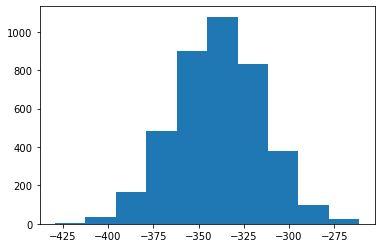

In [220]:
i = 0 
v_precalc = tre.get_precalclam()

tmp = (1-lambdas[i]) * (v_precalc['A_e_lj_' + str(i+1)] + v_precalc['A_e_crf_' + str(i+1)]) \
      + (lambdas[i]) * (v_precalc['B_e_lj_' + str(i+1)] + v_precalc['B_e_crf_' + str(i+1)])

print(min(tmp))

plt.hist(tmp)
plt.show()

In [13]:
def discard_high_energy_points(pot_i, threshold:int = 1000):
    """discard_high_energy_points
    This is a helper function, which will allow us to filter out
    some of the data we dont want to plot. The default value for the threshold
    is 1000 kJ/mol

    Parameters
    ----------
    pot_i : List[float]
        list of potential energies
    threshold: float, optional
        upper_threshold above which we discard data points (default 1000)

    Returns
    -------
    List[float]
        list of energies below the threshold
    """
    return [e for e in pot_i if e < threshold]


In [263]:
# Plot of v(lambda) for each sampled lambda
### i.e. the lambda used to construct the potential is the lambda used to generate coords.

-424.6408806
-398.82215606999995
-382.88965278
-372.55474994049996
-396.03708118
-442.630940225
-466.88048561100004
-469.37904462
-500.817112156
-490.57416241000004
-564.4045013
-568.459878145
-532.4525952399999
-561.4512339400001
-521.93236609
-559.894543825
-541.74821742
-545.3491196944999
-586.8011858699999
-654.8518489735001
-710.1823277999999


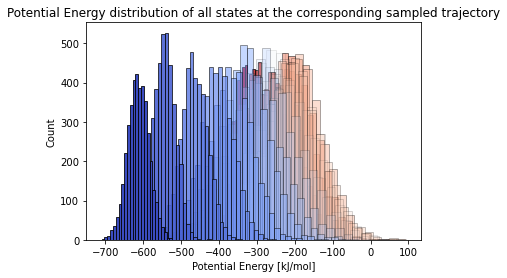

<BarContainer object of 21 artists>

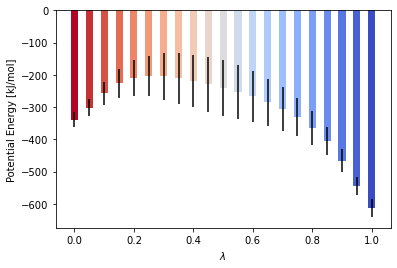

In [64]:
from matplotlib.pyplot import cm

color = iter(cm.rainbow(np.linspace(1, 0, 21)))
color = iter(cm.coolwarm(np.linspace(1, 0, 21)))


colors = []

avgs = []
stds = []

fig = plt.figure()
ax = plt.subplot(111)

for i, (lam, v_lam) in enumerate(zip(lambdas, v_lambdas)):
    c = next(color)
    colors.append(c)
    
    v_pot = discard_high_energy_points(2.479* v_lam[3997*i:3997*(i+1)])
    
    if lam < 0.25 or lam > 0.75 or True: 
        plt.hist(v_pot, bins=25, label = lam, alpha= abs(1-2*abs(1-lam)), color=c, 
                 edgecolor='black', linewidth = 0.8)
    
    avgs.append(np.average(v_pot))
    stds.append(np.std(v_pot))
    
    #print ('working on ' + str(lam) + ' we have ' + str(len(v_pot)) + ' elements.')
    print (min(v_pot))
    
#plt.ylim(0, 800)

plt.title('Potential Energy distribution of all states at the corresponding sampled trajectory')
plt.xlabel('Potential Energy [kJ/mol]')
plt.ylabel('Count')
#plt.legend(ncol=4)
plt.show()

# Alternate representation 

plt.ylabel('Potential Energy [kJ/mol]')
plt.xlabel(r'$\lambda$')
plt.bar(lambdas, avgs, yerr=stds, color = colors, width = 1/42)



In [249]:
np.shape(v_lambdas)

(21, 83937)

# Plot of V(lambda = 0 ) at all simulated lambdas 
### i.e. this allows us to see how much the potential w.r.t an end state evolves (becomes very high at other end state simulation essentially)

In [53]:
from matplotlib.pyplot import cm

color = iter(cm.rainbow(np.linspace(1, 0, 21)))


for i, (lam, v_lam) in enumerate(zip(lambdas, v_lambdas)):
    c = next(color)
    
    v_pot = discard_high_energy_points(2.479 * v_lambdas[0][3997*i:3997*(i+1)])
    
    plt.hist(v_pot, bins=25, label = lam, color=c, edgecolor='black', linewidth = 0.2)
    
    #print ('working on ' + str(lam) + ' we have ' + str(len(v_pot)) + ' elements.')
    #print (min(v_pot))

plt.title('Potential Energy distribution of state i at all sampled lambdas')
plt.xlabel('Potential Energy [kJ/mol]')
plt.ylabel('Count')
#plt.legend()
plt.show()


NameError: name 'discard_high_energy_points' is not defined

# Extract lowest energy frames of the TRE/TRC

In [79]:
from pygromos.files.trajectory.tre import Tre
from pygromos.files.trajectory.trc import Trc

In [82]:
leg = "1_2"
path_to_data = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/openff/complex/leg_'+leg+'/seed1/NIK_complex_openff_TI_'+leg+'_seed1_l_1.0/analysis/data'

tre_path = path_to_data + '/NIK_complex_openff_TI_'+leg+'_seed1_l_1.0.tre.h5'
trc_path = path_to_data + '/NIK_complex_openff_TI_'+leg+'_seed1_l_1.0.trc.h5'


In [83]:
tre = Tre(tre_path)

In [128]:
len(tre.database['precalclam'][0])

234

In [129]:
tre.get_precalclam()

,nr_lambdas,A_e_lj_1,B_e_lj_1,A_e_crf_1,B_e_crf_1,AB_kinetic_1,AB_bond_1,AB_angle_1,AB_improper_1,AB_disres_1,...,B_e_crf_21,AB_kinetic_21,AB_bond_21,AB_angle_21,AB_improper_21,AB_disres_21,AB_dihres_21,AB_disfld_21,A_dihedral,B_dihedral
0,21.0,1215.689495,-316.319500,-79.161643,126.508080,204.038310,0.0,0.0,0.0,0.0,...,-167.689640,204.038310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21.0,1548.364875,-322.216111,-84.482989,128.685530,214.335809,0.0,0.0,0.0,0.0,...,-201.887893,214.335809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.0,33082.595770,-324.931215,-108.996995,79.101282,210.058716,0.0,0.0,0.0,0.0,...,-180.810217,210.058716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21.0,2968.126388,-305.977194,-135.034939,-242.850900,204.755338,0.0,0.0,0.0,0.0,...,-186.624329,204.755338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21.0,-77.991988,-308.728459,-103.591693,-5.461662,238.626116,0.0,0.0,0.0,0.0,...,-187.496869,238.626116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,21.0,-31.325905,-340.153965,-132.882272,-97.475371,219.281422,0.0,0.0,0.0,0.0,...,-206.484396,219.281422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3989,21.0,47311.525000,-327.220016,-125.700314,-89.863408,220.493709,0.0,0.0,0.0,0.0,...,-191.558616,220.493709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3990,21.0,-56.103739,-327.631886,-88.705193,-34.817358,216.032586,0.0,0.0,0.0,0.0,...,-181.322668,216.032586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3991,21.0,-185.554393,-330.299417,-122.933756,89.123936,207.088804,0.0,0.0,0.0,0.0,...,-196.784449,207.088804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Backup no longer usefull code

In [152]:
"""
from pygromos.data.ene_ana_libs import std_ene_ana_lib

# This function will analyse the trgs (list of trgs given for the same lambda point).
# 
# 1) Extract dvdl with ene_ana from gromos++ for all sub_trgs at the same time
# 2) Store results in a way which we allow to perform a convergence analysis
def analyse_trgs_at_lambda(trgs, verbose:bool = True):
    
    # Find a base directory where we can store results 
    results_dir = '/'.join(trgs[0].split('/')[:-3]) + '/results'
        
    if not os.path.isdir(results_dir): os.mkdir(results_dir)
    os.chdir(results_dir)
    
    # Find the value of lambda used from the filename
    
    lam = float(trgs[0].split('/')[-1].split('_')[-2])
    
    print ('working on: \u03BB = ' + str(lam))
    
    out_prefix = 'dvdl_results'
    
    # Run gromos++ ene_ana if results don't already exist 
    if not os.path.isfile(out_prefix+'.dat'):
        result_file = gromPP.ene_ana(in_ene_ana_library_path=std_ene_ana_lib, 
                                            in_en_file_paths=trgs, 
                                            in_properties="dvdl",
                                            out_energy_folder_path=results_dir,
                                            out_files_prefix = 'dvdl_results',
                                            verbose = verbose, 
                                            single_file=True)
    else: result_file = out_prefix+'.dat'
    
    # load data into a numpy array
    data = np.loadtxt(result_file, skiprows =1)
    dvdl = data[:,1]
    
    # Analyse the dV/dlam in data[:,1] 
    num_slices = 1  
    slicing = (np.linspace(0, 1+0.0000000001, num_slices+1)[1:]*len(dvdl)).astype(int)
     
    avgs = np.zeros(num_slices)
    stdevs = np.zeros(num_slices)
    
    for i in range(0, num_slices):
        sub_dvdl = dvdl[0:slicing[i]]
        avgs[i] = np.average(sub_dvdl)
        stdevs[i] = np.std(sub_dvdl)
    
    # Here we will want to return the lambda value (as float), and average values of dvdl
    # for the n different convergence poitns (after each ns for simplicity)
    
    return lam, avgs, stdevs
"""
x =1